In [1]:
library(tidyverse)
library(leaps)
library(broom)
library(repr)
library(digest)
library(faraway)
library(mltools)
library(glmnet)
library(cowplot)
library(readxl)
library(GGally)
library(infer)
library(rsample)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:faraway’:

    happy




In [2]:
data1<-read.csv("most_subscribed.csv")
head(data1, 3)

,rank,Youtuber,subscribers,video.views,video.count,category,started
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,1,T-Series,"222,000,000","198,459,090,822","17,317",Music,2006
2,2,YouTube Movies,"154,000,000",0,0,Film & Animation,2015
3,3,Cocomelon - Nursery Rhymes,"140,000,000","135,481,339,848",786,Education,2006


In [3]:
row_sub = apply(data1, 1, function(row) all(row !=0 ))
data1 <- data1[row_sub,]
data <- data1[data1$category %in% c("Gaming", "Music", "Entertainment", "People & Blogs"),]


In [4]:
data$subscribers<- as.numeric(gsub(",","",data$subscribers))
data$video.views<- as.numeric(gsub(",","",data$video.views))
data$video.count<- as.numeric(gsub(",","",data$video.count))



In [14]:
data<-data[,-c(0:1)]
head(data,3)

,subscribers,video.views,video.count,category,started
,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,2.22e+08,198459090822,17317,Music,2006
6,1.11e+08,28469458228,4497,Gaming,2010
7,1.02e+08,16832456681,726,Entertainment,2012


In [25]:
#split data into test and training
split_data<-initial_split(data, prop=0.7, strata=video.views)
data_train<-training(split_data)
data_test<-testing(split_data)
head(data_train, 3)

,subscribers,video.views,video.count,category,started
,<dbl>,<dbl>,<dbl>,<chr>,<int>
131,30000000,2673017855,110,Gaming,2014
176,26300000,3589276436,553,Gaming,2016
212,24100000,2242631303,93,Entertainment,2012


In [26]:
full_interaction<-lm(video.views~video.count*subscribers+video.count*started+subscribers*started+video.count+subscribers+category+started+video.count*category+started*category+subscribers*category, data=data_train)
with_interaction<-lm(video.views~video.count+subscribers+category+started+video.count*category+started*category+subscribers*category, data=data_train)
new_model<-lm(video.views~video.count*subscribers+video.count+subscribers+category+started+video.count*category+started*category+subscribers*category, data=data_train)


In [27]:
#new model: think this is the model we should use: this has category interaction, and video.count*subscriber interaction
# it was seen in the summary for lm that the interaction is significant 
new_model<-lm(video.views~video.count*subscribers+video.count+subscribers+category+started+video.count*category+started*category+subscribers*category, data=data_train)
selection_model<-regsubsets(video.views~video.count*subscribers+video.count+subscribers+category+started+video.count*category+started*category+subscribers*category,
           data=data_train, 
           method="forward")
selection<-summary(selection_model)

data_summary_df <- tibble(
     n_input_variables = 1:8,
     RSQ = selection$rsq,
     RSS = selection$rss,
     ADJ.R2 = selection$adjr2,
     Cp = selection$cp,
     BIC = selection$bic,
 )
data_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7353163,1.854896e+22,0.7347579,230.924027,-620.3777
2,0.7628706,1.661796e+22,0.7618679,159.747659,-666.5388
3,0.7818225,1.528981e+22,0.7804358,111.416757,-700.0228
4,0.7911233,1.463802e+22,0.7893494,88.716520,-714.5943
5,0.8020773,1.387037e+22,0.7999717,61.626019,-734.0697
6,0.8157006,1.291565e+22,0.8133428,27.446318,-761.8503
7,0.8210642,1.253977e+22,0.8183878,15.202255,-769.7432
8,0.8243216,1.231149e+22,0.8213122,8.551323,-772.3230


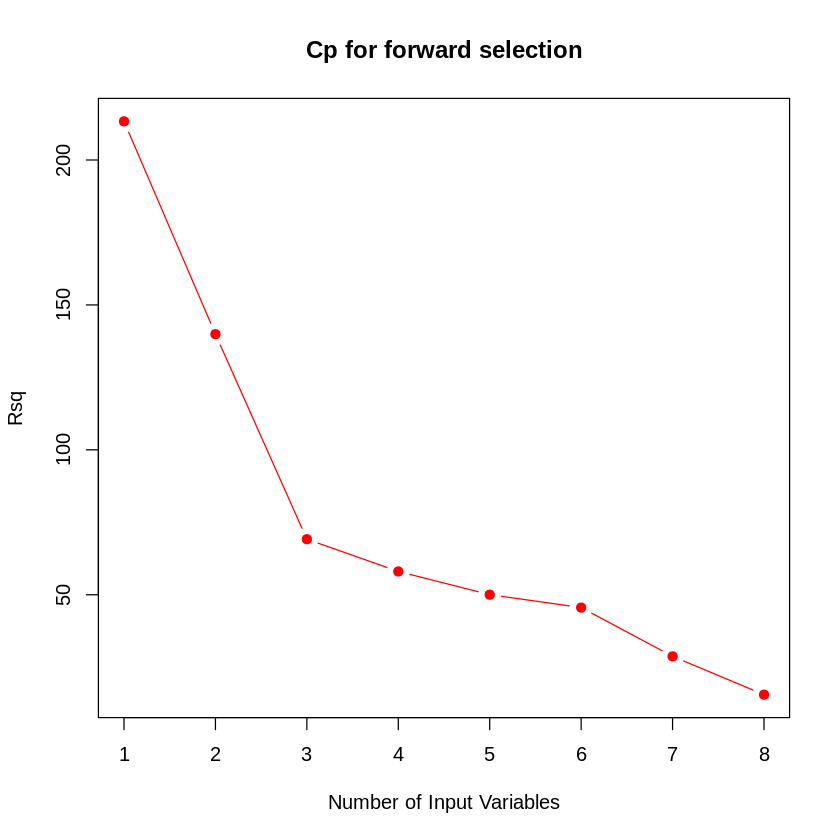

In [9]:
plot(summary(selection_model)$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "Rsq", type = "b", pch = 19,
  col = "red"
)

In [10]:
new_model_summary<-glance(new_model)%>% mutate_if(is.numeric, round, 3)
full_model_summary<-glance(full_interaction)%>% mutate_if(is.numeric, round, 3)
with_interaction_summary<-glance(with_interaction)%>% mutate_if(is.numeric, round, 3)
new_model_summary
full_model_summary
with_interaction_summary

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.799,0.792,5535821122,113.715,0,16,-11345.58,22727.17,22802.15,1.40662e+22,459,476


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8,0.792,5533270634,101.308,0,18,-11344.33,22728.65,22811.96,1.399201e+22,457,476


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.788,0.781,5668480452,114.203,0,15,-11357.37,22748.75,22819.56,1.478057e+22,460,476


1. lowest cp with 8 params and best adj.r^2
2. consider including interaction plots
3. Can use f-stat as model diagnostic, comparing for different models, higher the better (more the model explains the variation) 

In [11]:
anova_1<-anova(new_model, full_interaction)
anova_2<-anova(new_model, with_interaction)
anova_3<-anova(full_interaction, with_interaction)
anova_1
anova_2
anova_3

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,459,1.406620e+22,NA,NA,NA,NA
2,457,1.399201e+22,2,7.419246e+19,1.211619,0.2986695


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,459,1.406620e+22,NA,NA,NA,NA
2,460,1.478057e+22,-1,-7.143687e+20,23.31086,1.880343e-06


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,457,1.399201e+22,NA,NA,NA,NA
2,460,1.478057e+22,-3,-7.885611e+20,8.585198,1.483382e-05


In [12]:
prediction_model<-predict(new_model, newdata=data_test)
head(prediction_model, 3)

8          15          20 
69774680516 51411750615 45362640219

In [32]:
pair_plots <- data_train %>%
  select(- video.views) %>% 
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )


integer(0)

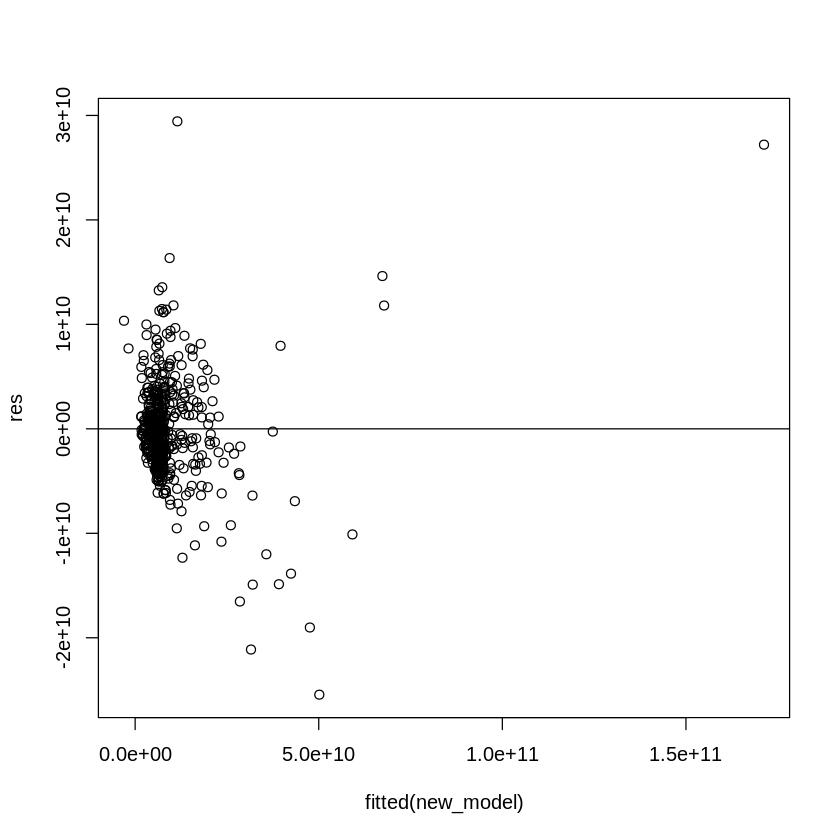

NULL

ERROR: Error in qqnorm(res) + qqline(res): non-numeric argument to binary operator


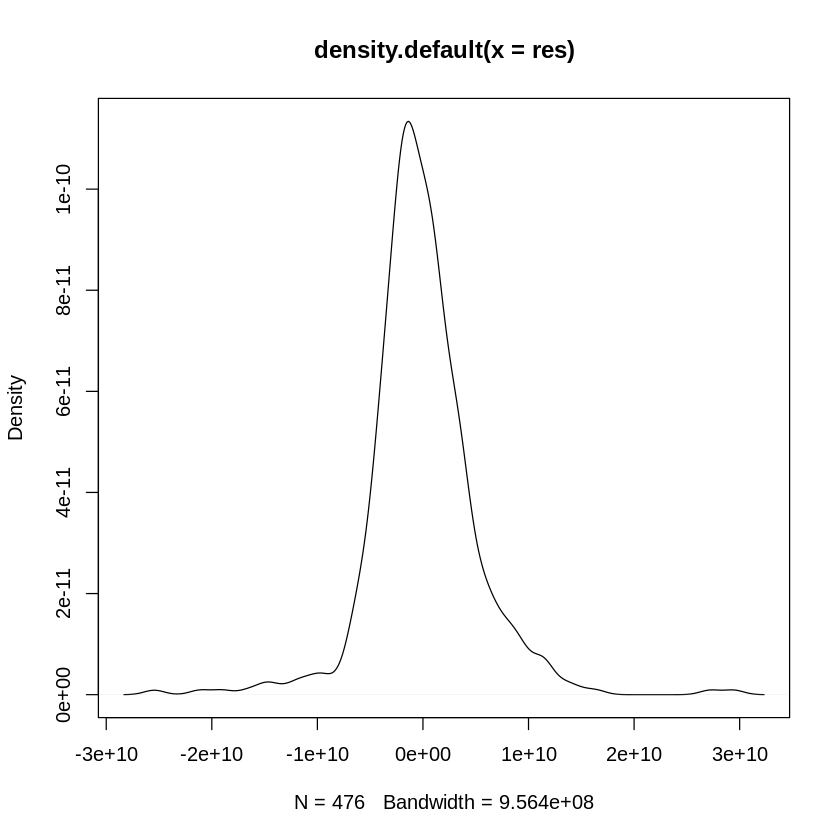

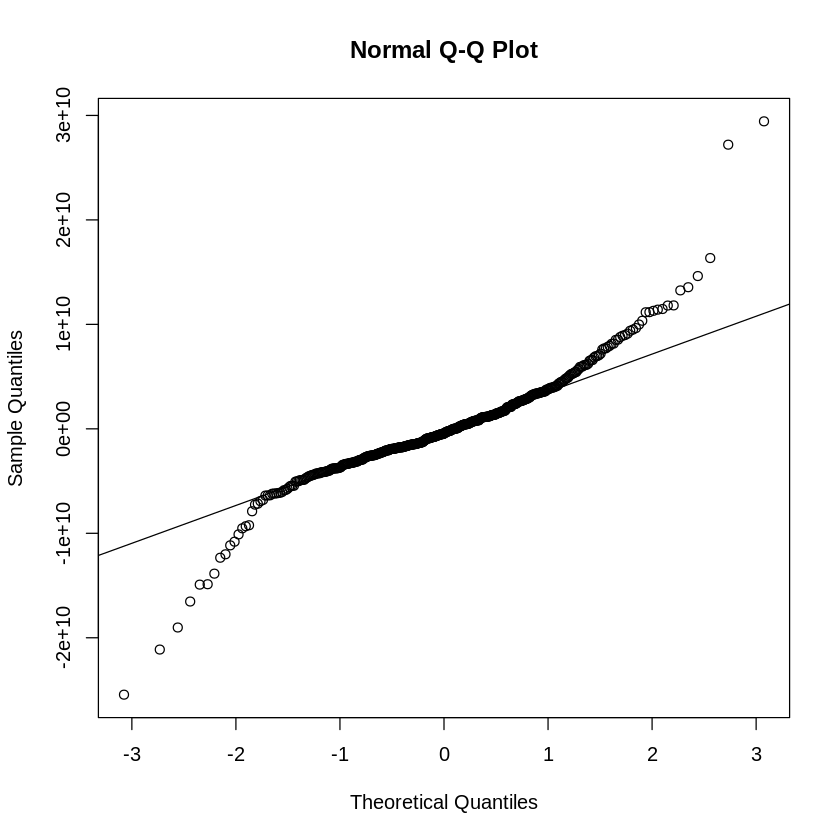

In [45]:
#residual plot
res<-resid(new_model)
resid_plot<-plot(fitted(new_model), res)+
    abline(0,0)
resid_plot
density_plot<-plot(density(res))
density_plot
qq_plot<-qqnorm(res)+
    qqline(res)
qq_lot


Assumptions: 
1. linearity: shows violation of Homoscedasticity (non-constant variance) 
2. Normally distributed residuals: from the qq plot we can see that the residuals near both tails do not follow a normal distribution, however, if we observe our density plot, we can see that the residuals appear relatively normally distributed (wiuth slight skewness) 

In [46]:
summary(data_train)

  subscribers         video.views         video.count         category        
 Min.   : 10900000   Min.   :1.066e+07   Min.   :    12.0   Length:476        
 1st Qu.: 12700000   1st Qu.:4.053e+09   1st Qu.:   278.0   Class :character  
 Median : 15200000   Median :6.702e+09   Median :   817.5   Mode  :character  
 Mean   : 19974580   Mean   :9.551e+09   Mean   :  7528.7                     
 3rd Qu.: 21750000   3rd Qu.:1.212e+10   3rd Qu.:  3096.8                     
 Max.   :222000000   Max.   :1.985e+11   Max.   :224455.0                     
    started    
 Min.   :2005  
 1st Qu.:2009  
 Median :2013  
 Mean   :2012  
 3rd Qu.:2015  
 Max.   :2021  

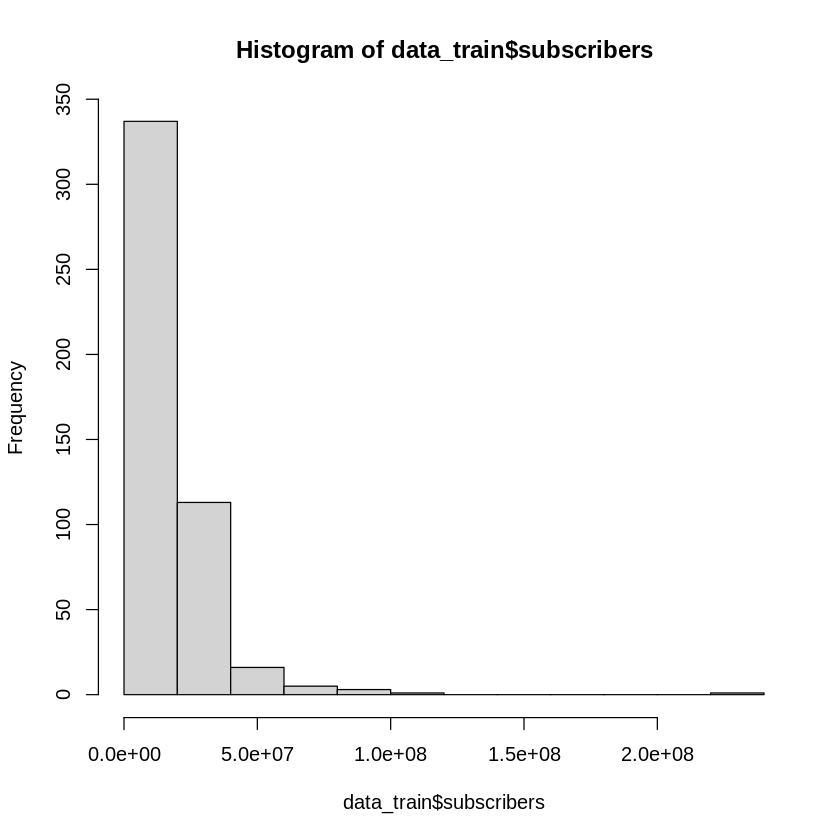

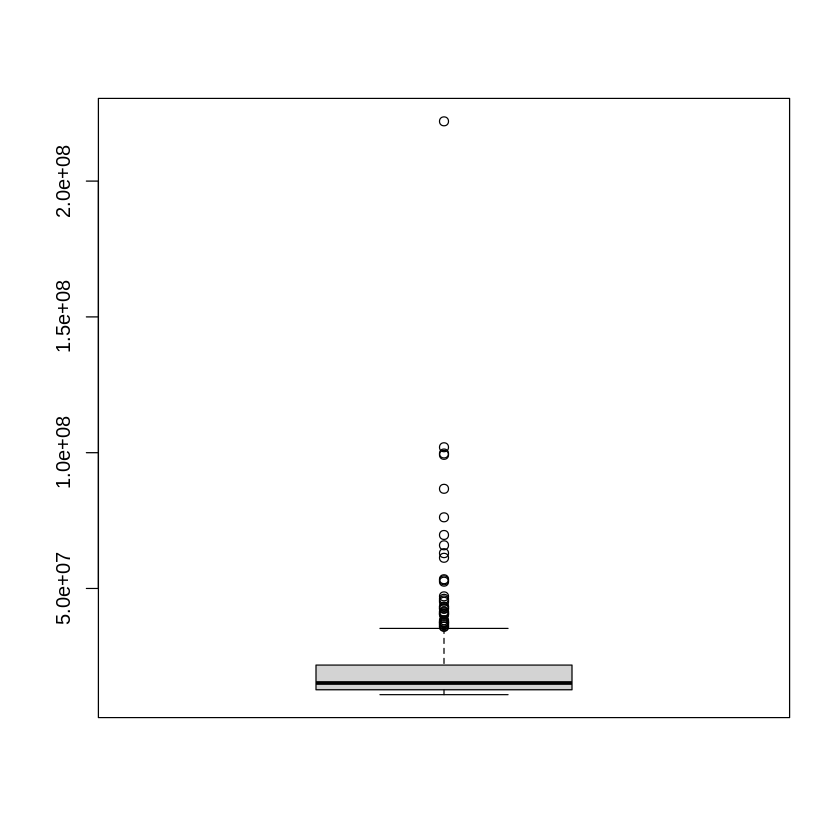

In [50]:
hist(data_train$subscribers)
boxplot(data_train$subscribers)



Topics to bring up: 
I think we should remove outliers, they could be leading to the non-normally distributed residuals and non-constant varaince, and thus leading to viiolations in the assumptions in regression... 
Note: actually, we should certainly remove the outliers from the data.... 
--> as we can see from the plot above, there is a clear outlier towards the right tail end of the data (and from boxplot)
--> if we want to remove them, refer to this page: https://statsandr.com/blog/outliers-detection-in-r/
